In [11]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns


In [ ]:
dataset_path="images"
# dataset_path looks like this:
# images
# images/train
# images/train/angry

# dataset link = https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

In [13]:
def split_data_classwise(source_dir, split_dir, test_size=0.2):
    """
    Splits data from source_dir into train and test sets class-wise 
    and saves them in split_dir.
    """
    train_dir = os.path.join(split_dir, 'train')
    test_dir = os.path.join(split_dir, 'test')

    # Iterate over each emotion class folder
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)

        # List all image files in this class
        image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) 
                       if f.endswith(('.jpg', '.png'))]

        # Split images into train and test sets for this class
        train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=42)

        # Create directories for train and test sets
        class_train_dir = os.path.join(train_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)
        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_test_dir, exist_ok=True)

        # Copy files to train and test directories
        for file in train_files:
            shutil.copy(file, class_train_dir)
        for file in test_files:
            shutil.copy(file, class_test_dir)

# Define dataset path and split directory
dataset_path = "../Face-_Emotion_Detection-Manual/Emotion_Detection_CNN-main/dataset/images/train"
split_dir = "./split_dataset"  # Save split images here

# Perform the split
split_data_classwise(dataset_path, split_dir)


In [14]:
IMG_WIDTH, IMG_HEIGHT = 48, 48
BATCH_SIZE = 32

# Define ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load data from split directories
train_generator = train_datagen.flow_from_directory(
    os.path.join(split_dir, 'train'),
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    os.path.join(split_dir, 'test'),
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Validation data generator (from provided validation folder)
val_generator = val_datagen.flow_from_directory(
    "../Face-_Emotion_Detection-Manual/Emotion_Detection_CNN-main/dataset/images/validation",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 23054 images belonging to 7 classes.
Found 5767 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [15]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(train_generator.num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 128)        

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stopping]
)


Epoch 1/25
721/721 [==============================] - 127s 175ms/step - loss: 1.8122 - accuracy: 0.2510 - val_loss: 1.6743 - val_accuracy: 0.3218
Epoch 2/25
721/721 [==============================] - 28s 39ms/step - loss: 1.6625 - accuracy: 0.3420 - val_loss: 1.5188 - val_accuracy: 0.4215
Epoch 3/25
721/721 [==============================] - 28s 39ms/step - loss: 1.5526 - accuracy: 0.3959 - val_loss: 1.4169 - val_accuracy: 0.4648
Epoch 4/25
721/721 [==============================] - 29s 40ms/step - loss: 1.4668 - accuracy: 0.4335 - val_loss: 1.3695 - val_accuracy: 0.4771
Epoch 5/25
721/721 [==============================] - 31s 43ms/step - loss: 1.4290 - accuracy: 0.4487 - val_loss: 1.3249 - val_accuracy: 0.4833
Epoch 6/25
721/721 [==============================] - 39s 54ms/step - loss: 1.3931 - accuracy: 0.4685 - val_loss: 1.2788 - val_accuracy: 0.5136
Epoch 7/25
721/721 [==============================] - 38s 53ms/step - loss: 1.3562 - accuracy: 0.4821 - val_loss: 1.2809 - val_accurac

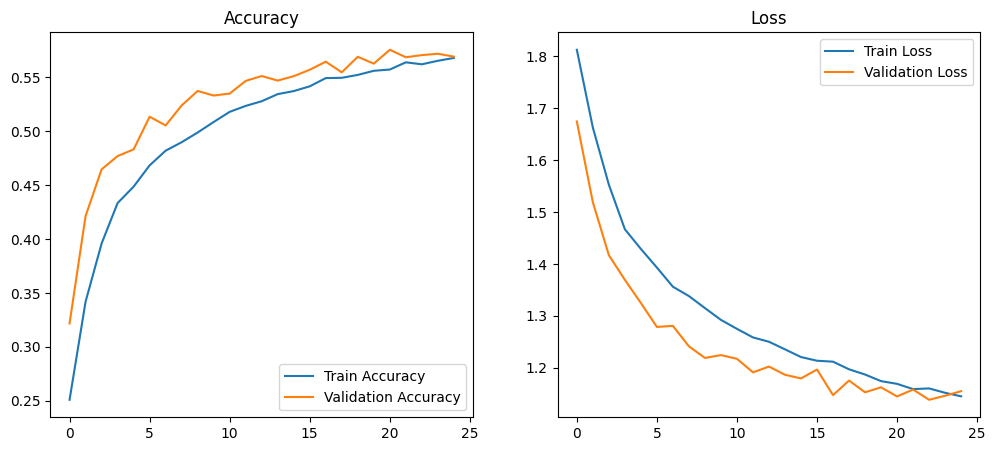

In [18]:
def plot_performance(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_performance(history)


181/181 [==============================] - 22s 122ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.48      0.49      0.48       799
     disgust       0.83      0.11      0.20        88
        fear       0.39      0.21      0.27       821
       happy       0.74      0.84      0.79      1433
     neutral       0.46      0.61      0.53       997
         sad       0.48      0.31      0.37       988
    surprise       0.57      0.81      0.67       641

    accuracy                           0.56      5767
   macro avg       0.56      0.48      0.47      5767
weighted avg       0.54      0.56      0.53      5767

Confusion Matrix:


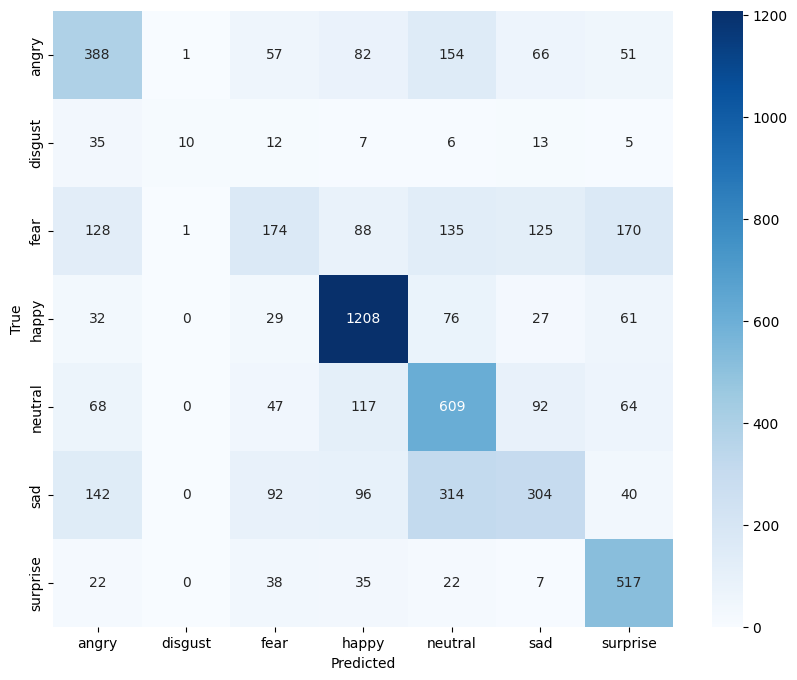

Accuracy: 0.56
Precision: 0.54
Recall: 0.56
F1 Score: 0.53


In [19]:
test_generator.reset()
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_labels))

print('Confusion Matrix:')
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


In [26]:
def predict_emotion(image_path):
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f'Predicted Emotion: {predicted_class}')
    plt.axis('off')
    plt.show()

# predict_emotion('../gpt-face-emotion-detection/split_dataset/test/disgust/758.jpg')
# predict_emotion('../gpt-face-emotion-detection\split_dataset/test/angry/126.jpg')
